<a href="https://colab.research.google.com/github/cclljj/LJ-test/blob/master/Chap_6_2_%E7%95%B0%E5%B8%B8%E8%B3%87%E6%96%99%E5%81%B5%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.2. 異常資料偵測

## 異常檢測框架

目前已有多個大規模微型空品監測系統成功部署於不同的國家與城市之中，然而這些微型感測器的主要挑戰之一為如何確保數據品質，並且能即時偵測出可能的異常現象。在台灣的中央研究院資訊科學研究所網路實驗室研究團隊，於2018年提出了一種可用於實際環境中的異常檢測框架，稱之為 [Anomaly Detection Framework](https://ieeexplore.ieee.org/document/8081731) (ADF)。

此異常檢測框架由四個模組所組成：

1. 時間片斷異常偵測 (Time-Sliced Anomaly Detection, TSAD)：可即時偵測感測器於空間或時間上的異常數據，並將結果輸出給其他模組進行進一步分析。
2. 即時污染偵測模組 (Real-time Emission Detection, RED)：可透過 TSAD 的偵測結果，即時檢測潛在的區域性污染事件。
3. 感測器可靠度評估模組 (Device Ranking, DR)：可累積 TSAD 的偵測結果，並據以評估每個微型感測器設備的可靠度
4. 非正常使用機器偵測模組 (Malfunction Detection, MD)：可累積 TSAD 的偵測結果，透過數據分析判別可能為非正常使用的微型感測器，例如安裝在室內的機器、安置在持續性污染源旁邊的機器等。

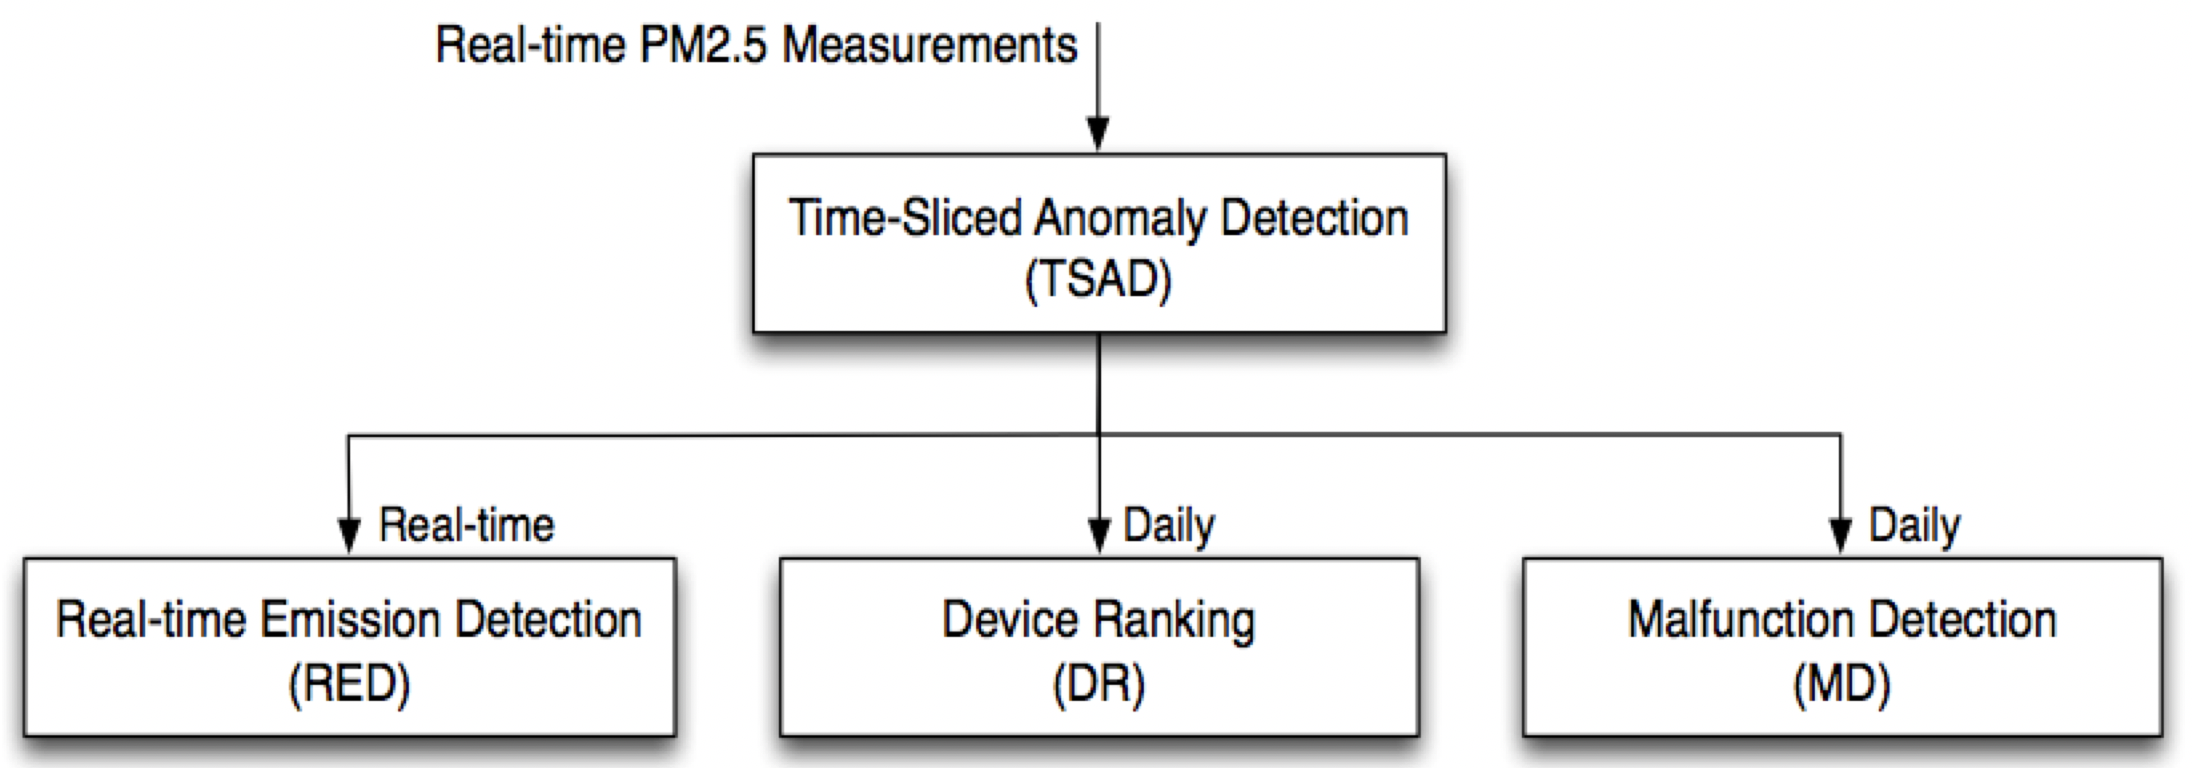

### 異常事件種類

在 ADF 框架中，TSAD 模組在微型感測器每次收到新的感測資料後，便會進行時間類或空間類的異常事件判斷，我們已微型空品感測器為例，進行說明：

- 時間類異常事件：我們假設空氣的擴散是均勻緩慢的，因此同一台微型空品感測器在短時間內的數值變化應極為平緩，如果有某台微型空品感測器的感測數值在短時間內出現劇烈的變化，代表在時間維度上可能出現異常事件。
- 空間類異常事件：我們可以假設戶外的空氣在地理空間上是會均勻擴散的，因此微型空品感測器的感測數值，理應與周圍鄰近的感測器相似，如果有某台微型空品感測器的感測數值，與同時間鄰近區域的微型空品感測器的感測數值出現極大的差異，代表該感測器所處的空間可能出現異常事件。

### 異常事件可能原因

以上所述的異常事件有許多可能的原因，常見的原因有：

- 安裝環境異常：感測器被安裝於特定環境，因此無法呈現整體環境現象，例如安裝於廟宇旁、燒烤店內或其他室內不通風的地點。
- 機器故障或安裝錯誤：例如感測器安裝時將取風口的方向弄錯，或者感測器的風扇積垢導致運轉不順暢。
- 出現臨時污染源：例如感測器旁邊剛好有人在抽菸、發生火災或排放污染物質。

## 實際案例演練

在這篇文章中，我們將以民生公共物聯網中的空品資料為例，使用部分佈建於高雄市的校園微型空品感測器來進行分析，並且介紹如何使用 ADF 檢測框架來找出其中可能為室內機器或位於污染源附近的機器，藉此過濾出可信度相對較低的機器們，進而提高整體空品感測結果的可信度。

### 套件安裝與引用

在這個案例中，我們將會使用到 pandas, numpy, plotly 和 geopy 等套件，這些套件在我們使用的開發平台 Google Colab 上已有預先提供，因此我們不需要另行安裝，可以直接用下列的方法引用，以備之後資料處理與分析使用。

In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
from geopy.distance import geodesic

### 讀取資料與環境設定

在這個案例中，我們將使用部分民生公共物聯網佈建於高雄的校園微型空品感測器來進行分析，我們所設定的時間和空間範圍如下：

- 地理區域：緯度: `22.631231 - 22.584989`, 經度: `120.263422 - 120.346764`
- 時間區間：2022.10.15 - 2022.10.28

註：校園微型空品感測器的原始資料請至 [民生公共物聯網-資料服務平台](https://ci.taiwan.gov.tw/dsp/)下載，為了方便讀者可以重現這個範例的內容和結果，我們先把所有使用到的資料整理成 `allLoc.csv` 檔案，做為接下來資料分析的依據。

我們首先載入資料檔案，並預覽資料的內容：

In [ ]:
DF = pd.read_csv("https://LearnCIOT.github.io/data/allLoc.csv")
DF.head()

,device_id,date,time,temperature,RH,PM2.5,lat,lon
0,74DA38F20F0C,2022-10-15,00:00:05,27.12,100.0,0.0,22.624,120.271
1,74DA38F207DE,2022-10-15,00:00:21,26.12,100.0,38.0,22.603,120.340
2,74DA38F20D8A,2022-10-15,00:01:02,27.00,100.0,32.0,22.606,120.337
3,74DA38F20A10,2022-10-15,00:01:45,25.75,100.0,19.0,22.631,120.311
4,74DA38F20B20,2022-10-15,00:02:14,25.25,98.0,0.0,22.626,120.304


接著我們擷取資料檔中每個感測器的 GPS 地理位置座標，由於這些感測器的 GPS 座標都不會改變，我們使用比較特別的方式，將資料檔中每個感測器的精度和緯度資料各自取平均值，做為該感測器的地理位置座標。

In [ ]:
dfId = DF[["device_id","lon","lat"]].groupby("device_id").mean().reset_index()
print(dfId.head())

      device_id      lon     lat
0  74DA38F207DE  120.340  22.603
1  74DA38F20A10  120.311  22.631
2  74DA38F20B20  120.304  22.626
3  74DA38F20B80  120.350  22.599
4  74DA38F20BB6  120.324  22.600


為了大致了解資料檔內感測器的地理位置分布，我們將感測器的位置繪製在地圖上。

In [ ]:
fig_map = px.scatter_mapbox(dfId, lat="lat", lon="lon",
                  color_continuous_scale=px.colors.cyclical.IceFire, zoom=9,
                  mapbox_style="carto-positron")
fig_map.show()

### 尋找鄰近的感測器

由於我們所使用的校園微型空氣品質感測器都是固定安裝在校園內，其 GPS 地理位置座標並不會改變，為了節省之後資料分析的運算時間，我們先統一將每個感測器的「鄰居」清單計算出來。在我們的案例中，我們定義如果兩個微型感測器的相互距離小於等於 3 公里，那麼這兩個感測器變互為鄰居關係。

我們首先撰寫一個小函式 `countDis`，可以針對輸入的兩個 GPS 地理座標位置，計算兩者之間的實體公里距離。

In [ ]:
def countDis(deviceA, deviceB):
    return geodesic((deviceA["lat"], deviceB['lon']), (deviceB["lat"], deviceB['lon'])).km

接著我們將原有資料的感測器列表從 DataFrame 資料型態，轉化成 Dictionary 資料型態，並且計算所有任意兩個感測器間的距離，只要兩者間的距離小於 3km，便將彼此存入對方的鄰居感測器列表 dicNeighbor 中。

In [ ]:
# set the maximum distance of two neighbors
DISTENCE = 3

## convert Dataframe -> Dictionary
# {iD: {'lon': 0.0, 'lat': 0.0}, ...}
dictId = dfId.set_index("device_id").to_dict("index")

## obtain the list of sensor device_id
listId = dfId["device_id"].to_list()

## initialize dicNeighbor
# {iD: []}
dicNeighbor = {iD: [] for iD in listId}

## use countDis to calculate distance of every two sensors
# The two sensors are deem to be neighbors of each other if their distance is less than 3km
# Time complexity: N!
for x in range(len(listId)):
    for y in range(x+1, len(listId)):
        if ( countDis( dictId[listId[x]], dictId[listId[y]]) < DISTENCE ):
            dicNeighbor[listId[x]].append( listId[y] )
            dicNeighbor[listId[y]].append( listId[x] )

### 每五分鐘進行感測資料的時間切片

由於原始資料中每個感測器的感測資料在時間上並未同步，在 ADF 框架中提出將感測資料以每單位時間為間隔，獲取整體感測結果的時間切片 (time slice)。我們首先將原始資料中的 `date` 和 `time` 兩個欄位進行整併，並以 Python 語言中的 datetime 時間資料型態，儲存形成 `datetime` 新欄位，接著再將原有的 `date`、`time`、`RH`、`temperature`、`lat`、`lon` 等不需要的欄位刪除。

In [ ]:
# combine the 'date' and 'time' columns to a new column 'datetime'
DF["datetime"] = DF["date"] + " " + DF["time"]

# remove some non-necessary columns
DF.drop(columns=["date","time", "RH","temperature","lat","lon"], inplace=True)

# convert the new 'datetime' column to datetime data type
DF['datetime'] = pd.to_datetime(DF.datetime)

由於我們所處理的校園微型空氣品質感測器的資料頻率約為 5 分鐘，因此我們將時間切片的單位時間 `FREQ` 也設為 5 分鐘，並計算每五分鐘內，每個感測器所回傳的感測值的平均值。為了確保資料正確性，我們也多做了一道檢查，將 PM2.5 感測值為負數的資料予以刪除。

In [ ]:
FREQ = '5min'
dfMean = DF.groupby(['device_id', pd.Grouper(key = 'datetime', freq = FREQ)]).agg('mean')

# remove invalid records (i.e., PM2.5 < 0)
dfMean = dfMean[ dfMean['PM2.5'] >= 0 ]
print(dfMean.head())

                                  PM2.5
device_id    datetime                  
74DA38F207DE 2022-10-15 00:00:00   38.0
             2022-10-15 00:05:00   37.0
             2022-10-15 00:10:00   37.0
             2022-10-15 00:20:00   36.0
             2022-10-15 00:25:00   36.0


### 以時間切片為單位計算鄰居感測器的平均感測值

為了計算在特定時間切片上，特定感測器的鄰居感測器的平均感測值，我們撰寫 `cal_mean` 函式，可以根據輸入的特定感測器代碼 `iD` 與時間戳記 `dt`，回傳該感測器的鄰居感測器數量與平均感測值。

In [ ]:
def cal_mean(iD, dt):
  neighborPM25 = dfMean[ 
              (dfMean.index.get_level_values('datetime') == dt) 
              & (dfMean.index.get_level_values(0).isin(dicNeighbor[iD])) 
              ]["PM2.5"]

  avg = neighborPM25.mean()
  neighbor_num = neighborPM25.count()
  return avg, neighbor_num

接著我們針對 dfMean 中每台感測器的每個時間戳記，計算其鄰居感測器的數量與平均感測值，並分別存入 `avg` 與 `neighbor_num` 兩個新欄位中。比較特別的是，這邊我們使用 zip 和 apply 的語法，可以將 DataFrame 的數值帶入函式當中進行運算，其中：

1. 我們使用 `zip` 的語法，用於打包 `apply_func` 所回傳的兩個參數值。
2. 我們使用 `apply` 的語法，以配合 DataFrame 的規則，接收 `apply_func` 的回傳值。

In [ ]:
def apply_func(x):
  return cal_mean(x.name[0], x.name[1])

dfMean['avg'], dfMean['neighbor_num'] = zip(*dfMean.apply(apply_func, axis=1))
print(dfMean.head())

                                  PM2.5        avg  neighbor_num
device_id    datetime                                           
74DA38F207DE 2022-10-15 00:00:00   38.0  13.400000            10
             2022-10-15 00:05:00   37.0  19.888889             9
             2022-10-15 00:10:00   37.0  16.500000            12
             2022-10-15 00:20:00   36.0  16.750000             8
             2022-10-15 00:25:00   36.0  17.000000            11


### 判斷異常事件的門檻值

我們透過觀察發現，所謂的「異常事件」指的是感測器的感測值，與我們心中認定的合理值有過大的差距，這個合理值有可能是鄰近的感測器感測值（空間類異常），也有可能是同一個感測器的前一筆感測值（時間類異常），或者是根據其他資訊來源的合理推估值。同時，我們也發現所謂的「過大的差距」，其實是一個很模糊的說法，其具體數值隨感測值的大小，亦有極大的不同。

因此，我們首先根據現有 `dfMean[’avg']` 的分布狀況，切分為 9 個區間，並且針對每一個區間的 PM2.5 感測值，計算其標準差，並據以做為判斷感測值是否異常的門檻值標準，如下表所示。舉例來說，當原始數值為 10 (ug/m3) 時，倘若周圍感測器平均高於 `10+6.6` ，或低於 `10+6.6` ，我們便會認定該感測器的該筆感測值為異常事件。

| 原始數值 (ug/m3) | 門檻值標準 |
| --- | --- |
| 0-11 | 6.6 |
| 12-23 | 6.6 |
| 24-35 | 9.35 |
| 36-41 | 13.5 |
| 42-47 | 17.0 |
| 48-58 | 23.0 |
| 59-64 | 27.5 |
| 65-70 | 33.5 |
| 71+ | 91.5 |

根據這個對照表，我們撰寫下列的函示 `THRESHOLD`，根據輸入的感測數值，回傳對應的門檻值，並將此門檻值存入 `dfMEAN` 的新欄位 `PM_thr` 中。

In [ ]:

def THRESHOLD(value):
    if value<12:
        return 6.6
    elif value<24:
        return 6.6
    elif value<36:
        return 9.35
    elif value<42:
        return 13.5
    elif value<48:
        return 17.0
    elif value<54:
        return 23.0
    elif value<59:
        return 27.5
    elif value<65:
        return 33.5
    elif value<71:
        return 40.5
    else:
        return 91.5

dfMean['PM_thr'] = dfMean['PM2.5'].apply(THRESHOLD)

由於原始資料的最後一筆紀錄的時間是 2022-10-28 23:45，因此我們將資料判斷的時間設為 2022-10-29 日，並將原始資料中每一筆紀錄與資料判斷時間的差距，存入 `dfMEAN` 的新欄位 `days` 中。接著我們先預覽一下目前 `dfMEAN` 資料表的狀況。

In [ ]:
TARGET_DATE = "2022-10-29"
dfMean = dfMean.assign(days = lambda x: ( (pd.to_datetime(TARGET_DATE + " 23:59:59") - x.index.get_level_values('datetime')).days ) )
print(dfMean.head())

                                  PM2.5        avg  neighbor_num  PM_thr  days
device_id    datetime                                                         
74DA38F207DE 2022-10-15 00:00:00   38.0  13.400000            10    13.5    14
             2022-10-15 00:05:00   37.0  19.888889             9    13.5    14
             2022-10-15 00:10:00   37.0  16.500000            12    13.5    14
             2022-10-15 00:20:00   36.0  16.750000             8    13.5    14
             2022-10-15 00:25:00   36.0  17.000000            11    13.5    14


### 非正常使用機器偵測模組 (MD) 實作

在接下來的範例中，我們實作 ADF 中的非正常使用機器偵測模組 (Malfulction Detection, MD)，其核心觀念為，倘若我們將某一個微型感測器的 PM2.5 數值與其周圍 3 公里內的其他感測器進行比較，如果其感測數值低於鄰近感測器的平均值 (`avg`) 減掉可接受的門檻值 (`PM_thr`)，則將該機器 ˋ視為裝設在室內的機器（標記為`indoor`）；如果其感測數值高於鄰近感測器的平均值 (`avg`) 加上可接受的門檻值 (`PM_thr`)，則將該機器視為裝設在污染源旁的機器（標記為`emission`）。為了避免因為參考的鄰近感測器數量不夠導致誤判，我們只採計鄰近區域存有多於 2 個其他感測器的案例。

In [ ]:
MINIMUM_NEIGHBORS = 2

dfMean["indoor"] = ((dfMean['avg'] - dfMean['PM2.5']) > dfMean['PM_thr']) & (dfMean['neighbor_num'] >= MINIMUM_NEIGHBORS)
dfMean["emission"] = ((dfMean['PM2.5'] - dfMean['avg']) > dfMean['PM_thr']) & (dfMean['neighbor_num'] >= MINIMUM_NEIGHBORS)

dfMean

PM2.5        avg  neighbor_num  PM_thr  \
device_id    datetime                                                      
74DA38F207DE 2022-10-15 00:00:00   38.0  13.400000            10    13.5   
             2022-10-15 00:05:00   37.0  19.888889             9    13.5   
             2022-10-15 00:10:00   37.0  16.500000            12    13.5   
             2022-10-15 00:20:00   36.0  16.750000             8    13.5   
             2022-10-15 00:25:00   36.0  17.000000            11    13.5   
...                                 ...        ...           ...     ...   
74DA38F210FE 2022-10-28 22:55:00    3.0  16.666667            12     6.6   
             2022-10-28 23:00:00    3.0  19.642857            14     6.6   
             2022-10-28 23:10:00    3.0  18.307692            13     6.6   
             2022-10-28 23:20:00    2.0  19.545455            11     6.6   
             2022-10-28 23:45:00    2.0  16.615385            13     6.6   

                                  days  indoor  emission  
device_id    datetime                                     
74DA38F207DE 2022-10-15 00:00:00    14   False      True  
             2022-10-15 00:05:00    14   False      True  
             2022-10-15 00:10:00    14   False      True  
             2022-10-15 00:20:00    14   False      True  
             2022-10-15 00:25:00    14   False      True  
...                                ...     ...       ...  
74DA38F210FE 2022-10-28 22:55:00     1    True     False  
             2022-10-28 23:00:00     1    True     False  
             2022-10-28 23:10:00     1    True     False  
             2022-10-28 23:20:00     1    True     False  
             2022-10-28 23:45:00     1    True     False  

[52523 rows x 7 columns]

由於每日的空氣品質狀況不同，對於 `indoor` 和 `emission` 的判斷結果也會產生不同程度的影響，為了獲得更有說服力的判斷結果，我們考慮過去 1 天、7 天、 14 天等三個時間長度，分別計算在不同時間長度下，同一個感測器被判斷為 `indoor` 或 `emission` 的比例。同時，為了避免外在環境導致的誤判影響最後的判斷結果，我們強制修改計算出來的結果，將比例小於 1/3 的數值，強制改為 0。

In [ ]:
# initialize
dictIndoor = {iD: [] for iD in listId}
dictEmission = {iD: [] for iD in listId}

for iD in listId:
    dfId = dfMean.loc[iD]
    for day in [1, 7, 14]:
        indoor = (dfId[ dfId['days'] <= day]['indoor'].sum() / len(dfId[ dfId['days'] <= day])).round(3)
        dictIndoor[iD].append( 
            indoor if indoor > 0.333 else 0
        )
        
        emission = (dfId[ dfId['days'] <= day]['emission'].sum() / len(dfId[ dfId['days'] <= day])).round(3)
        dictEmission[iD].append(
            emission if emission > 0.333 else 0
        )

我們接著分別列印出 `dictIndoor` 和 `dictEmission` 的內容，觀察判斷出來的結果。

In [ ]:
dictIndoor

{'74DA38F207DE': [0, 0, 0],
 '74DA38F20A10': [0, 0, 0],
 '74DA38F20B20': [0.995, 0.86, 0.816],
 '74DA38F20B80': [0.995, 0.872, 0.867],
 '74DA38F20BB6': [0, 0, 0],
 '74DA38F20C16': [0.989, 0.535, 0],
 '74DA38F20D7C': [0, 0, 0],
 '74DA38F20D8A': [0, 0, 0],
 '74DA38F20DCE': [0, 0, 0],
 '74DA38F20DD0': [0.984, 0.871, 0.865],
 '74DA38F20DD8': [0, 0.368, 0.369],
 '74DA38F20DDC': [0, 0, 0],
 '74DA38F20DE0': [0, 0, 0],
 '74DA38F20DE2': [0, 0, 0],
 '74DA38F20E0E': [0, 0, 0],
 '74DA38F20E42': [0.99, 0.866, 0.87],
 '74DA38F20E44': [0, 0, 0],
 '74DA38F20F0C': [0.979, 0.872, 0.876],
 '74DA38F20F2C': [0, 0, 0],
 '74DA38F210FE': [0.99, 0.847, 0.864]}

In [ ]:
dictEmission

{'74DA38F207DE': [0.92, 0.737, 0.735],
 '74DA38F20A10': [0, 0, 0],
 '74DA38F20B20': [0, 0, 0],
 '74DA38F20B80': [0, 0, 0],
 '74DA38F20BB6': [0.492, 0.339, 0],
 '74DA38F20C16': [0, 0, 0],
 '74DA38F20D7C': [0.553, 0.342, 0.337],
 '74DA38F20D8A': [0.672, 0.457, 0.388],
 '74DA38F20DCE': [0.786, 0.556, 0.516],
 '74DA38F20DD0': [0, 0, 0],
 '74DA38F20DD8': [0, 0, 0],
 '74DA38F20DDC': [0.345, 0, 0],
 '74DA38F20DE0': [0.601, 0.503, 0.492],
 '74DA38F20DE2': [0, 0, 0],
 '74DA38F20E0E': [0.938, 0.75, 0.75],
 '74DA38F20E42': [0, 0, 0],
 '74DA38F20E44': [0.938, 0.69, 0.6],
 '74DA38F20F0C': [0, 0, 0],
 '74DA38F20F2C': [0.744, 0.575, 0.544],
 '74DA38F210FE': [0, 0, 0]}

由上述的結果可以發現，對於 indoor 和 emission 的判斷結果，隨著參考的過往時間長短，存在不小的差異，由於不同過往時間的長度代表不同的參考意義，因此我們使用權重的方式，給予 1 天參考時間 `A` 的權重，給予 7 天參考時間 `B` 的權重，最後給予 14 天參考時間 `1-A-B` 的權重。

同時，我們考量在一天參考時間內的工作時間約為 24 小時中的 8 小時，七天參考時間內的工作時間約為 168 小時中的 40 小時，14 天參考時間內的工作時間約為 336 小時中的 80 小時，因此若一個感測器被判斷為 `indoor` 或 `emission` 類型，其在 MD 中所佔的加權比重應大於等於 `MD_thresh`，且 

`MD_thresh` = (8.0/24.0)*A+(40.0/168.0)B+(80.0/336.0)(1-A-B)

在我們的範例中，我們假定 `A=0.2`，`B=0.3`，因此我們可以透過下列的程式獲得加權判斷後的 `indoor` 和 `emission` 類別感測器清單。

In [ ]:
A=0.2
B=0.3
MD_thresh=(8.0/24.0)*A+(40.0/168.0)*B+(80.0/336.0)*(1-A-B)

listIndoorDevice = []
listEmissionDevice = []

for iD in listId:
    rate1 = A*dictIndoor[iD][0] + B*dictIndoor[iD][1] + (1-A-B)*dictIndoor[iD][2]
    if rate1 > MD_thresh:
        listIndoorDevice.append( (iD, rate1) )

    rate2 = A*dictEmission[iD][0] + B*dictEmission[iD][1] + (1-A-B)*dictEmission[iD][2]
    if rate2 > MD_thresh:
        listEmissionDevice.append( (iD, rate2) )

我們接著分別列印出 `listIndoorDevice` 和 `listEmissionDevice` 的內容，觀察透過加權判斷出來的結果。

In [ ]:
listIndoorDevice

[('74DA38F20B20', 0.865),
 ('74DA38F20B80', 0.8941),
 ('74DA38F20C16', 0.3583),
 ('74DA38F20DD0', 0.8906),
 ('74DA38F20DD8', 0.2949),
 ('74DA38F20E42', 0.8928),
 ('74DA38F20F0C', 0.8954),
 ('74DA38F210FE', 0.8841)]

In [ ]:
listEmissionDevice

[('74DA38F207DE', 0.7726),
 ('74DA38F20D7C', 0.38170000000000004),
 ('74DA38F20D8A', 0.4655),
 ('74DA38F20DCE', 0.5820000000000001),
 ('74DA38F20DE0', 0.5171),
 ('74DA38F20E0E', 0.7876),
 ('74DA38F20E44', 0.6945999999999999),
 ('74DA38F20F2C', 0.5933)]

### 即時污染偵測模組 (RED) 實作

針對即時污染偵測 (Real-time Emission Detection, RED)，我們假設某個微型感測器在連續的取樣中，如果最新的感測數值比前一次的感測數值多出 1/5 以上，代表其周遭環境出現劇烈的變化，極有可能是因為周遭出現空汙的排放現象。由於當感測數值較小時，1/5 的變化量其實在 PM2.5 的真實濃度變化上仍十分輕微，因此我們也排除感測數值小於 20 的狀況，以避免因為感測器本身的誤差導致即時污染偵測的誤判。

In [ ]:
dfMean['red'] = False
for iD in listId:
    dfId = dfMean.loc[iD]
    p_index = ''
    p_row = []
    for index, row in dfId.iterrows():
      red = False
      if p_index:
        diff = row['PM2.5'] - p_row['PM2.5']
        if p_row['PM2.5']>20 and diff>p_row['PM2.5']/5:
          red = True

      dfMean.loc[pd.IndexSlice[iD, index.strftime('%Y-%m-%d %H:%M:%S')], pd.IndexSlice['red']] = red
      p_index = index
      p_row = row

dfMean

PM2.5        avg  neighbor_num  PM_thr  \
device_id    datetime                                                      
74DA38F207DE 2022-10-15 00:00:00   38.0  13.400000            10    13.5   
             2022-10-15 00:05:00   37.0  19.888889             9    13.5   
             2022-10-15 00:10:00   37.0  16.500000            12    13.5   
             2022-10-15 00:20:00   36.0  16.750000             8    13.5   
             2022-10-15 00:25:00   36.0  17.000000            11    13.5   
...                                 ...        ...           ...     ...   
74DA38F210FE 2022-10-28 22:55:00    3.0  16.666667            12     6.6   
             2022-10-28 23:00:00    3.0  19.642857            14     6.6   
             2022-10-28 23:10:00    3.0  18.307692            13     6.6   
             2022-10-28 23:20:00    2.0  19.545455            11     6.6   
             2022-10-28 23:45:00    2.0  16.615385            13     6.6   

                                  days  indoor  emission    red  
device_id    datetime                                            
74DA38F207DE 2022-10-15 00:00:00    14   False      True  False  
             2022-10-15 00:05:00    14   False      True  False  
             2022-10-15 00:10:00    14   False      True  False  
             2022-10-15 00:20:00    14   False      True  False  
             2022-10-15 00:25:00    14   False      True  False  
...                                ...     ...       ...    ...  
74DA38F210FE 2022-10-28 22:55:00     1    True     False  False  
             2022-10-28 23:00:00     1    True     False  False  
             2022-10-28 23:10:00     1    True     False  False  
             2022-10-28 23:20:00     1    True     False  False  
             2022-10-28 23:45:00     1    True     False  False  

[52523 rows x 8 columns]

### 感測器可靠度評估模組 (DR) 實作

最後，我們總結 RED 與 MD 兩個模組的判斷結果，進行微型感測器的可靠度評估 (Device Ranking, DR)，其主要概念為：

- 如果感測器的感測資料常常被判定為時間類異常或空間類異常，代表該感測器的硬體，或者其所屬的環境可能有潛在的問題，需要進一步釐清。
- 如果感測器的感測資料較少被判定為異常，代表該感測器的感測數值與周遭感測器的數值具備很高的一致性，因此可信度高。

我們以日為單位，根據每個感測器每日的所有感測資料，統計曾經被判斷為時間類異常 (red=True) 或空間類異常 (indoor=True 或 emission=True) 的總次數，並計算其占一日所有資料筆數中的比例，以此做為感測器的資訊是否可靠的依據。

In [ ]:
device_rank = pd.DataFrame()
for iD in listId:
    dfId = dfMean.loc[iD]
    abnormal = {}
    num = {}
    for index, row in dfId.iterrows():
      d = index.strftime('%Y-%m-%d')
      if d not in abnormal:
        abnormal[d] = 0
      if d not in num:
        num[d] = 0
      num[d] = num[d] + 1
      if row['indoor'] or row['emission'] or row['red']:
        abnormal[d] = abnormal[d] + 1
        
    for d in num:
      device_rank = device_rank.append(pd.DataFrame({'device_id': [iD], 'date': [d], 'rank': [1 - abnormal[d]/num[d]]}))
device_rank.set_index(['device_id','date'])

rank
device_id    date                
74DA38F207DE 2022-10-15  0.047170
             2022-10-16  0.077273
             2022-10-17  0.578947
             2022-10-18  0.417910
             2022-10-19  0.252427
...                           ...
74DA38F210FE 2022-10-24  0.043478
             2022-10-25  0.456897
             2022-10-26  0.536364
             2022-10-27  0.025641
             2022-10-28  0.010000

[278 rows x 1 columns]

## 參考資料

- Ling-Jyh Chen, Yao-Hua Ho, Hsin-Hung Hsieh, Shih-Ting Huang, Hu-Cheng Lee, and Sachit Mahajan. ADF: an Anomaly Detection Framework for Large-scale PM2.5 Sensing Systems. IEEE Internet of Things Journal, volume 5, issue 2, pp. 559-570, April, 2018. ([https://dx.doi.org/10.1109/JIOT.2017.2766085](https://dx.doi.org/10.1109/JIOT.2017.2766085))